## Define Imports and Determine Device

In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Define Imports and Determine Device
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
os.sys.path.insert(0, "source")
from DiabetesData import DiabeticData
from Autoencoder import ConvAutoencoder
from VGGAutoencoder import VGGAutoencoder
from ConvVarAutoencoder import ConvVAE
from DogCatData import DogCatData
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
datatype="diabetes"
batch_size=16
epochs = 0
model_file = "models/VGGAE_diabetes_10.pth"
normalize=False
size=96

cuda


# read in data

In [3]:
if datatype == "diabetes":
    filename = "data/trainLabels_ad.csv"
    root_dir = "data/diabetes_original"
    task = ([0],[4])
    # task = ([0,1,2], [3,4])
#     task = ([0,1], (2,3,4))
    classes = ["none", "severe"]
    train = pd.read_csv("data/diabetes_ad_train.csv")
    val = pd.read_csv("data/diabetes_ad_valid.csv")
    test = pd.read_csv("data/diabetes_ad_test.csv")
#     data = pd.read_csv(filename)
#     train, not_train = train_test_split()

    print(Counter(train['level']))
    print(Counter(val['level']))
    print(Counter(test['level']))
    data = {'train': DiabeticData(df = train, transform_key="train", root_dir=root_dir, task = task, normalize = normalize),
            'valid': DiabeticData(df = val, transform_key="valid", root_dir=root_dir, task = task, normalize = normalize),
            'test': DiabeticData(df = test, transform_key="test", root_dir=root_dir, task = task, normalize = normalize)
            }


elif datatype == "dogcat":
    filename = "data/dogcat_ad.csv"
    root_dir = "data/dogcat/train"
    classes = ['dog', 'cat']
    # task = ([0,1,2], (3,4))

    train = pd.read_csv("data/dogcat_ad_train.csv")
    val = pd.read_csv("data/dogcat_ad_valid.csv")
    test = pd.read_csv("data/dogcat_ad_test.csv")
    print(Counter(train['text_label']))
    print(Counter(val['text_label']))
    print(Counter(test['text_label']))
    data = {'train': DogCatData(df = train, transform_key="train", root_dir=root_dir, normalize = normalize),
            'valid': DogCatData(df = val, transform_key="valid", root_dir=root_dir, normalize = normalize),
            'test': DogCatData(df = test, transform_key="test", root_dir=root_dir, normalize = normalize)
            }



elif datatype == "fruit":
    classes = ["apple", "banana"]
    root_dir="data/Fruit-Images-Dataset-master"
    train = pd.read_csv("data/fruit_ad_train.csv")
    val = pd.read_csv("data/fruit_ad_valid.csv")
    test = pd.read_csv("data/fruit_ad_test.csv")
    print(Counter(train['text_label']))
    print(Counter(val['text_label']))
    print(Counter(test['text_label']))
    data = {'train': DogCatData(df = train, transform_key="train", root_dir=root_dir, normalize = normalize),
            'valid': DogCatData(df = val, transform_key="valid", root_dir=root_dir, normalize = normalize),
            'test': DogCatData(df = test, transform_key="test", root_dir=root_dir, normalize = normalize)
            }

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
} 

Counter({0: 23226})
Counter({0: 1305, 4: 341})
Counter({0: 1279, 4: 367})
       Unnamed: 0  Unnamed: 0.1             image  level
0           23248         31705  40036_right.jpeg      0
1            3849          5240    6586_left.jpeg      0
2           10544         14464   18147_left.jpeg      0
3           16706         22819  28799_right.jpeg      0
4           11499         15746   19729_left.jpeg      0
...           ...           ...               ...    ...
23221       18453         25200   31916_left.jpeg      0
23222        9982         13702   17191_left.jpeg      0
23223       24683         33618   42467_left.jpeg      0
23224       10118         13887  17425_right.jpeg      0
23225       24112         32878   41528_left.jpeg      0

[23226 rows x 4 columns]
task = ([0], [4])
      Unnamed: 0  Unnamed: 0.1             image  level
0          21865         29832   37726_left.jpeg      0
1          14013         19225  24247_right.jpeg      0
2          18102         24690

In [4]:
model = VGGAutoencoder(device=device, task=datatype)
# model = ConvAutoencoder(device=device, task=datatype)
# model = ConvVAE(4, device=device, task=datatype)
print(model)
if model_file != "":
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

model.fit(epochs, dataloaders["train"], dataloaders["valid"])


VGGAutoencoder(
  (enc): VGGEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1

<Figure size 432x288 with 0 Axes>

/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

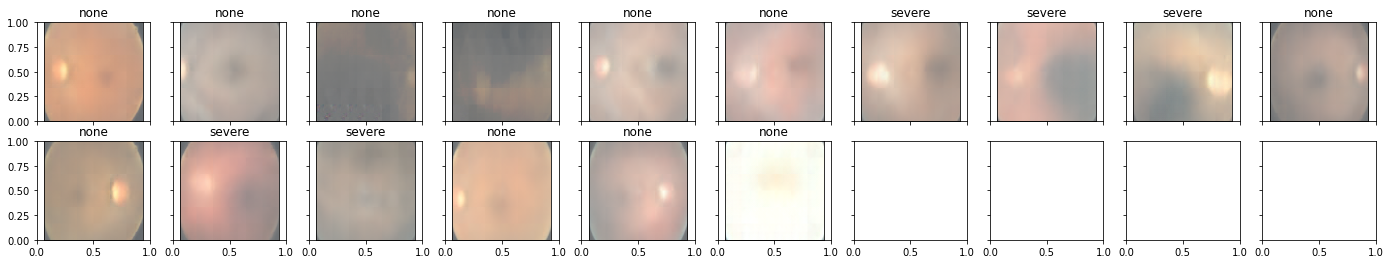

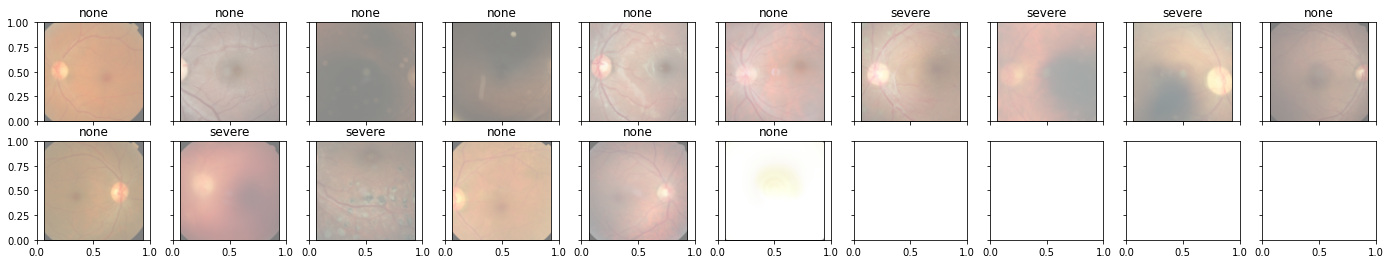

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))


# obtain one batch of test images
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# output = F.softmax(output)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, size, size)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


Now, we loop through the training set and calculate reconstruction loss 

In [6]:
dataloaders['valid'] = DataLoader(data['valid'], batch_size=1, shuffle=True)
dataloaders['test'] = DataLoader(data['test'], batch_size=1, shuffle=True)

results = []
results_cols = ["Image Label", "Reconstruction Loss"]
for x, y in dataloaders['valid']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        # ls = model.criterion(output, image)
        results.append([label, ls])

results = pd.DataFrame(results, columns=results_cols)
results.to_csv("reconstruction_error.csv")


#find error threshold on validation set



#evaluate on testing data

     Image Label  Reconstruction Loss
0              0           854.285034
1              0           917.091614
2              0           681.692749
3              0          1387.419678
4              0          4034.210449
...          ...                  ...
1641           1           477.724060
1642           0          5525.838867
1643           0           891.042053
1644           0           486.625427
1645           0          1147.428711

[1646 rows x 2 columns]
     Image Label  Reconstruction Loss
0              0           854.285034
1              0           917.091614
2              0           681.692749
3              0          1387.419678
4              0          4034.210449
...          ...                  ...
1638           0           618.267212
1642           0          5525.838867
1643           0           891.042053
1644           0           486.625427
1645           0          1147.428711

[1305 rows x 2 columns]
     Image Label  Reconstruction Loss


Text(0, 0.5, 'Frequency')

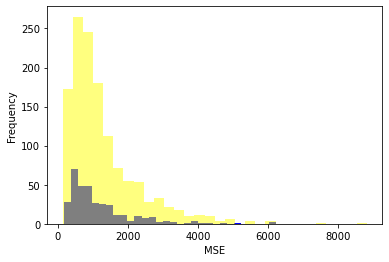

In [7]:
print(results)
label_1 = results[results["Image Label"] == 1]
label_0 = results[results["Image Label"] == 0]
print(label_0)
print(label_1)
avg_1 = np.mean(label_1['Reconstruction Loss'].values)
avg_0 = np.mean(label_0['Reconstruction Loss'].values)

print("Average Reconstruction Error (Prediction = 0)", avg_0)
print("Average Reconstruction Error (Prediction = 1)", avg_1)

plt.hist(label_1['Reconstruction Loss'].values, density=False, bins=30, color='blue')
plt.hist(label_0['Reconstruction Loss'].values, density=False, bins=30, alpha = 0.5,color='yellow')
plt.xlabel('MSE')
plt.ylabel('Frequency')


In [ ]:
results = {}
results["accuracy"] = []
results["precision"] = []
results["recall"] = []
results["f1"] = []
results["threshold"] = []
for threshold in range(0,10000,100):
    y_true = []
    y_pred = []
    for x, y in dataloaders['valid']:
        X = x.to(device)
        output = model(X)
        output = output.cpu().detach().numpy()
        for i in range(y.shape[0]):
            ls = 0
            image = x[i].numpy()
            ouptut = output[i]
            label = y[i].numpy()
            ls = np.sum(np.square(image.ravel() - output.ravel()))
    #         print("Label: {0}\tReconstruction Loss: {1}\tPrediction: {2}".format(label,ls,int(ls >= threshold)))
            y_true.append(label)
            if ls >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)

    accuracy = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    results["accuracy"].append(accuracy)
    results["precision"].append(prec)
    results["recall"].append(rec)
    results["f1"].append(f1)
    results["threshold"].append(threshold)
    print("Threshold: ", threshold)
    print("Accuracy: ", accuracy)
    print("Precision: ", prec)
    print("Recall: ", rec)
    print("F1-Score: ", f1)
    print("Confusion Matrix: ", cm)
    print()

Threshold:  0
Accuracy:  0.20716889428918592
Precision:  0.20716889428918592
Recall:  1.0
F1-Score:  0.34323100150981384
Confusion Matrix:  [[   0 1305]
 [   0  341]]

Threshold:  100
Accuracy:  0.20716889428918592
Precision:  0.20716889428918592
Recall:  1.0
F1-Score:  0.34323100150981384
Confusion Matrix:  [[   0 1305]
 [   0  341]]

Threshold:  200
Accuracy:  0.21628189550425272
Precision:  0.2087170042971148
Recall:  0.9970674486803519
F1-Score:  0.3451776649746193
Confusion Matrix:  [[  16 1289]
 [   1  340]]

Threshold:  300
Accuracy:  0.2448359659781288
Precision:  0.21163682864450128
Recall:  0.9706744868035191
F1-Score:  0.34750656167979
Confusion Matrix:  [[  72 1233]
 [  10  331]]

Threshold:  400
Accuracy:  0.2825030376670717
Precision:  0.21153846153846154
Recall:  0.9032258064516129
F1-Score:  0.3427935447968837
Confusion Matrix:  [[ 157 1148]
 [  33  308]]

Threshold:  500
Accuracy:  0.3153098420413123
Precision:  0.20317220543806647
Recall:  0.7888563049853372
F1-Score:

In [ ]:
plt.plot(results['threshold'], results['accuracy'], label='accuracy')
plt.plot(results['threshold'], results['f1'])
plt.plot(results['threshold'], results['precision'])
plt.plot(results['threshold'], results['recall'])
ax.legend()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Accuracy: ", accuracy)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-Score: ", f1)
print("Confusion Matrix: ", cm)